In [133]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import smart_resize
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset
! mv kaggle-cat-vs-dog-dataset.zip /content/drive/MyDrive/datasets

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
mv: cannot stat 'kaggle-cat-vs-dog-dataset.zip': No such file or directory


In [3]:
! unzip -q /content/drive/MyDrive/datasets/kaggle-cat-vs-dog-dataset.zip '*/PetImages/*'
! mv ./kagglecatsanddogs_3367a/PetImages/ ./PetImages
! rm -r ./kagglecatsanddogs_3367a/

In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [77]:
size = (128,128)

train_ds = keras.utils.image_dataset_from_directory(
    'PetImages',
    labels="inferred",
    class_names=['Cat', 'Dog'],
    batch_size=32,
    image_size=size,
    seed=0,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
)

test_ds = keras.utils.image_dataset_from_directory(
    'PetImages',
    labels="inferred",
    class_names=['Cat', 'Dog'],
    batch_size=32,
    image_size=size,
    seed=0,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
)

Found 23379 files belonging to 2 classes.
Using 18704 files for training.
Found 23379 files belonging to 2 classes.
Using 4675 files for validation.


In [78]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [79]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [80]:
input = keras.Input(shape=(*size, 3))

x = data_augmentation(input)
x = layers.Rescaling(1.0 / 255)(x)

x = layers.Conv2D(16, (3, 3), activation='relu',)(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',)(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',)(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation = 'sigmoid')(x)
cnn_model = keras.Model(input, output)
cnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 61, 61, 16)        2320      
                                                           

In [81]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],)

history = cnn_model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
585/585 [==============================] - 28s 45ms/step - loss: 0.6456 - accuracy: 0.6135 - val_loss: 0.5769 - val_accuracy: 0.7040
Epoch 2/50
585/585 [==============================] - 27s 45ms/step - loss: 0.5327 - accuracy: 0.7312 - val_loss: 0.4959 - val_accuracy: 0.7609
Epoch 3/50
585/585 [==============================] - 27s 45ms/step - loss: 0.4812 - accuracy: 0.7694 - val_loss: 0.4360 - val_accuracy: 0.7996
Epoch 4/50
585/585 [==============================] - 27s 45ms/step - loss: 0.4405 - accuracy: 0.7954 - val_loss: 0.4333 - val_accuracy: 0.7998
Epoch 5/50
585/585 [==============================] - 27s 46ms/step - loss: 0.4132 - accuracy: 0.8079 - val_loss: 0.4122 - val_accuracy: 0.8111
Epoch 6/50
585/585 [==============================] - 27s 45ms/step - loss: 0.4000 - accuracy: 0.8200 - val_loss: 0.4369 - val_accuracy: 0.7976
Epoch 7/50
585/585 [==============================] - 26s 45ms/step - loss: 0.3844 - accuracy: 0.8245 - val_loss: 0.3538 - val_accuracy:

In [134]:
predict_ds = keras.utils.image_dataset_from_directory(
    'PetImages',
    labels="inferred",
    class_names=['Cat', 'Dog'],
    batch_size=25,
    image_size=size,
    seed=10,
    interpolation="bilinear",
)

Found 23379 files belonging to 2 classes.


In [149]:
np.array([0.5,1,7], dtype=int)

array([0, 1, 7])

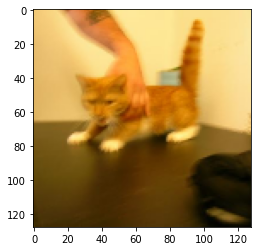

In [155]:
plt.imshow(np.array(smart_resize(cv2.imread(f'./PetImages/Cat/0.jpg')[...,::-1], size), dtype=int))

In [145]:
cnn_model.predict(np.array([smart_resize(cv2.imread(f'./PetImages/Cat/0.jpg')[...,::-1], size)]))

array([[0.5146575]], dtype=float32)

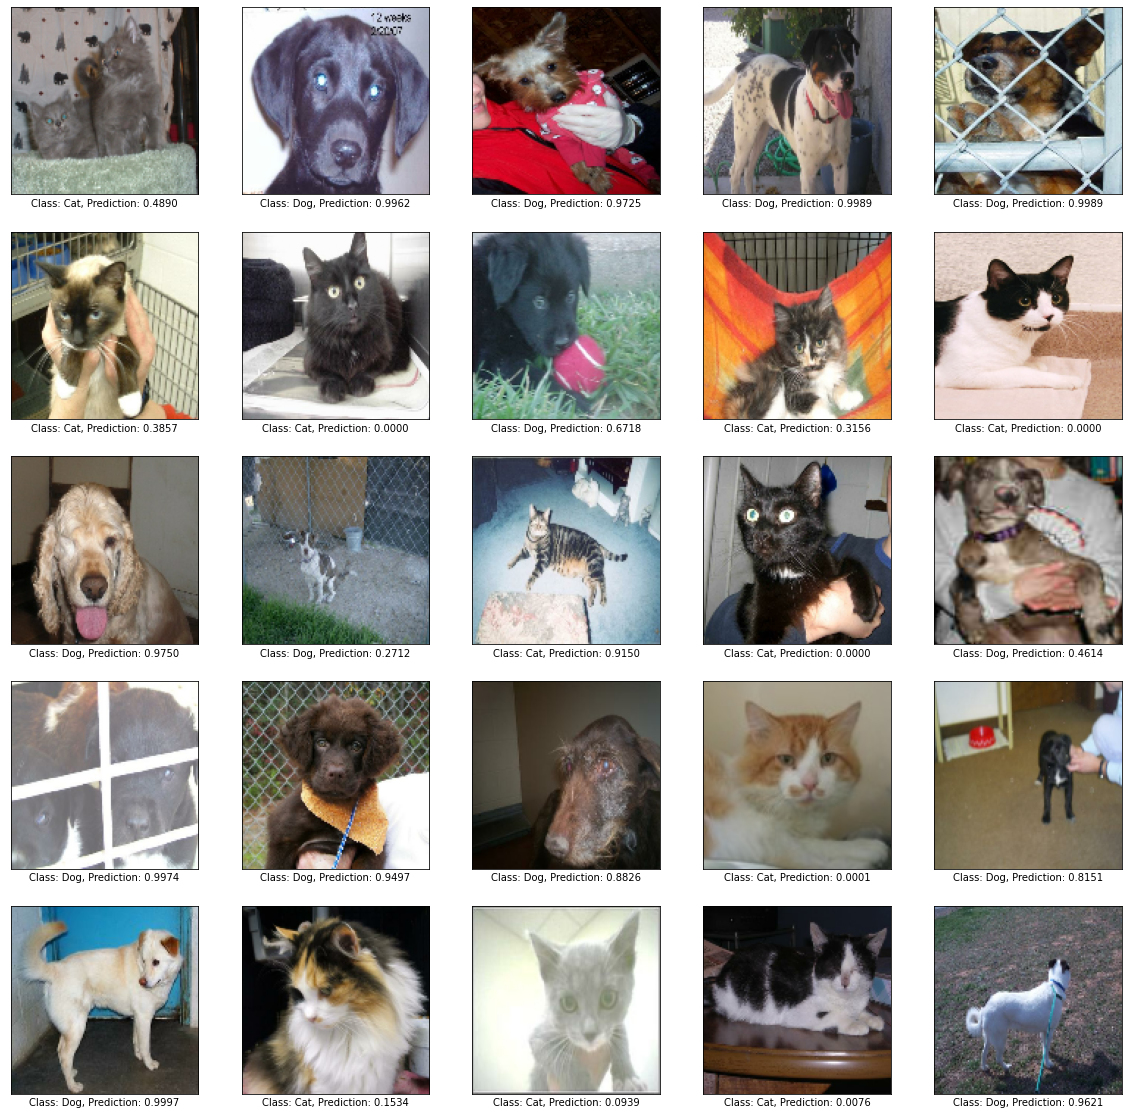

In [191]:
classes = ['Cat', 'Dog']
plt.figure(figsize=(20,20))
images, lables = next(iter(predict_ds))
preds = cnn_model.predict(images)

for i, (image, label, pred) in enumerate(zip(images, lables, preds)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(image/255)
  plt.xlabel(f'Class: {classes[label.numpy()]}, Prediction: {pred[0]:.4f}')

plt.show()

In [205]:
def faulty_predictions():
  for images, lables in iter(predict_ds):
    preds = cnn_model.predict(images)
    for image, label, pred in zip(images, lables, preds):
      faulty_predictions.count += 1
      if int(np.round(pred)) != label:
        yield image, label, pred

fault_iterator = faulty_predictions()

Looked at 383 images


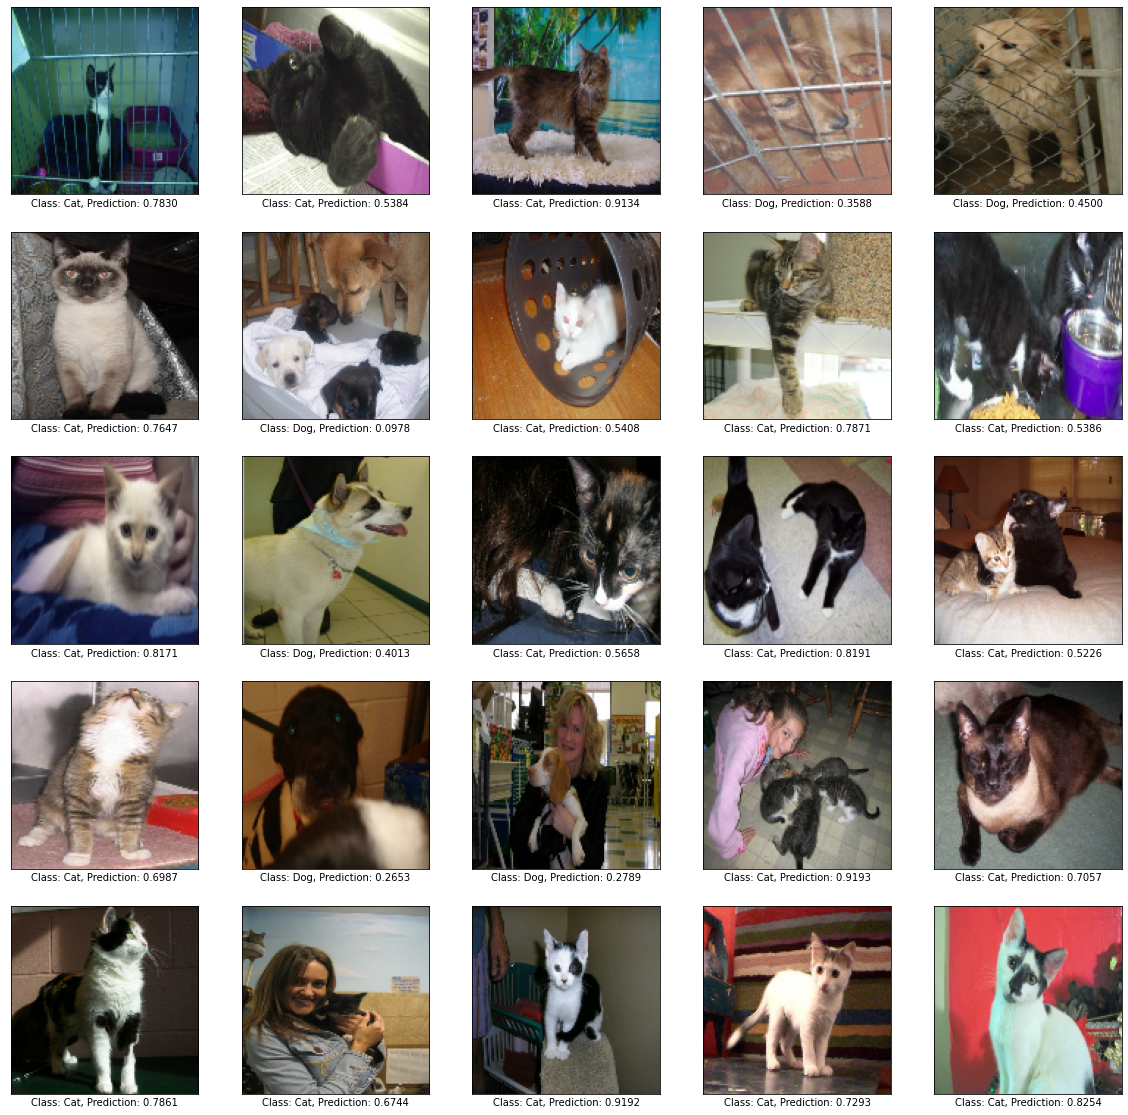

In [208]:
faulty_predictions.count = 0
plt.figure(figsize=(20,20))
for i, (image, label, pred) in zip(range(25), fault_iterator):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(image/255)
  plt.xlabel(f'Class: {classes[label.numpy()]}, Prediction: {pred[0]:.4f}')

print(f'Looked at {faulty_predictions.count} images')
plt.show()